In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import mesa_reader as ms
import pickle
import os
import seaborn as sns

import pandas as pd

In [2]:
class ModelData:
    
    def __init__(self, m, v, fov, profile):
        
        self.mass = m
        self.v = v
        self.fov = fov
        self.prof = profile
        self.chi = 1e99
        self.freq = []
        self.em = []
        self.ell = []

In [42]:
### run 1
masses = [10.2,10.4,10.6,10.8,11.0,11.2,11.4,11.6]
# overshoot = [0, 0.01, 0.02, 0.03, 0.04]
# velocity = [148,150,152,154,156,158,160]

###run 2 
# masses = [12.0,12.5,13.0,13.5,14.0]#,14.5,15.0,15.5]
overshoot = [0, 0.01, 0.02, 0.03, 0.04]
velocity = [148,150,152,154,156,158,160]

### g modes: sec 12, then sec 39
# ObsFreqs = np.sort([0.8365624314275338, 0.8798081090544078, 0.6758062472077946, 0.5095776379540266, 0.4004657747040583, 0.3402393882989552])
# ObsFreqs = np.sort([0.8377928346656643, 0.6731103364821193, 0.5277885212606825, 0.50343987421785960, 0.33676438901781813])
# ObsFreqs = np.sort([0.8365624314275338, 0.8798081090544078, 0.5095776379540266, 0.4004657747040583])
# ObsFreqs = np.sort([0.8377928346656643, 0.5277885212606825, 0.50343987421785960])


### p modes: sec 12, then sec 39
ObsFreqs = np.sort([9.358694761363909, 6.6821159857294115, 5.3206807629814, 4.678063607168428, 4.34950511386238, 3.8651658887176117, 3.4764497197053403])
# ObsFreqs = np.sort([9.305774937430675, 6.678512414603683, 5.3158585050535505, 4.680078520649031, 4.342428999073887, 4.19557630203085, 3.8650442321757352, 3.521319210034315])

In [43]:
def chigrid(m,CheckBestValue=False, nad=False):
    chilist = []
    ModelFits = []
    ModelFitspd = []
    # for m in masses:
    for fov in overshoot:
        for v in velocity:
            bestchiprofile = 30
#             print('hi')
            directory = '../mesafolder/work/LOGS/M'+str(m)+'_alpha'+str(fov)+'_v'+str(v)
#             flist = glob.glob(directory + "/lowgfrequencies*_split.txt")
#             flist = glob.glob(directory + "/lowmgmodefrequencies*_split.txt")
            flist = glob.glob(directory + "/lowmpmodefrequencies*_split.txt")
#             flist = glob.glob(directory + "/pmodefrequencies*_split.txt")
#             flist = glob.glob(directory + "/highmpmodefrequenciessept*_split.txt")
#             flist = glob.glob(directory + "/highmgmodefrequenciesoct*_split.txt")
#             print(flist)
            for f in flist:
                profile = f.split('_')
#                 print(profile)
                if profile[3] == 'split':
#                 if profile[3] == 'nad.txt':
                    print(profile[3])
                    continue
#                 print(profile[3])
                # CHANGE THIS CHARACTER TO WHATEVER IS THE LAST BEFORE * in TXT FILE (s, or t..)
                profile = profile[2].split('s')[1]
#                 print(profile)
                ModFileName = directory+"/profile"+str(profile)+".data"

                Model = ModelData(m,v,fov,profile)
                star = ms.MesaData(ModFileName)


                # read frequency data
                FreqFile = open(f)
                data = np.loadtxt(FreqFile, skiprows=6)
                FreqFile.close()
                if data.ndim < 2:
                    continue
                    
                Model.mass = data[0,1]
                radius = data[0,2]
                #split
                if nad ==False:
                    ell = data[:,5]
                    em = data[:,6] 
                    ModelFreqs = data[:,3]
                if nad == True:
                #nad
                    ell = data[:,7]
                    em = data[:,8]
                    ModelFreqs = data[:,5]
                    ModelGrowth = data[:,4]
                
                #nad
#                 ell = data[:,7]
#                 em = data[:,8]
#                 ModelFreqs = data[:,5]
#                 ModelGrowth = data[:,4]

    
            #pos, intrinsically excited, negative is damped
                #model growth for nad!
                # get mass and radius for scaling

#                 scalefactor = np.sqrt(6.672e-8 * Model.mass / (radius)**3) / (2 * np.pi)
    #                 ModelFreqs = ModelFreqs * scalefactor * 86400 # put frequencies in c/d

                # find differences in model vs observed frequencies:
                chiSquare = 0
                Model.ell = np.zeros(len(ObsFreqs))
                Model.em = np.zeros(len(ObsFreqs))
                Model.freqs = np.zeros(len(ObsFreqs))
#                 print(ModelFreqs)
                i = 0
                if nad ==True:
                    if len(ModelFreqs[ModelGrowth>0]) < 1:
                        continue
                else:
                    if len(ModelFreqs) < 1:
                    #print('here')
                        continue
                for freq in ObsFreqs:
                    ### also needs to be switched!
#                     bestIndex = np.argmin(np.abs(freq-ModelFreqs[ModelGrowth>0]))
                    bestIndex = np.argmin(np.abs(freq-ModelFreqs))
                    chiSquare +=(freq - ModelFreqs[bestIndex])**2
                    Model.ell[i] = ell[bestIndex]
                    Model.em[i] = em[bestIndex]
                    Model.freqs[i] = ModelFreqs[bestIndex]
                #print("Freq list", ModelFreqs,bestIndex)

                    i = i + 1

                chiSquare = chiSquare/len(ObsFreqs)
                if chiSquare < Model.chi:
                    Model.chi = chiSquare
#                     print(Model.chi)
                ModelFits.append(Model)
                ModelFitspd.append([Model.mass/1.989e33, Model.v, Model.fov, int(Model.prof), round(Model.chi, 3)])
            # making list of chi values in order
                if Model.chi < bestchiprofile:
                    bestchiprofile = Model.chi
            chilist.append(bestchiprofile)    
        
    
    #checking the BestFit
    BestFit = ModelData(1,1,1,1)
    #compares to that model, then to every model after
    for m in ModelFits:
        if m.chi < BestFit.chi:
            BestFit = m
    if CheckBestValue == True:
#         print(BestFit.mass/1.989e33, BestFit.v, BestFit.fov, BestFit.prof, BestFit.chi)
        print(BestFit.mass/1.989e33, BestFit.v, BestFit.fov, BestFit.prof)
    #make chi array
    chiarray = np.empty((len(overshoot),len(velocity)))
    index = 0
    for i in range(len(overshoot)):
        for j in range(len(velocity)):
            chiarray[i][j] = chilist[index]
            index +=1  
#     print(Model.freqs,ObsFreqs)
    return chiarray#, chilist, ModelFitspd
    return BestFit.chi

In [21]:
print(chigrid(14.0,CheckBestValue=True))
### G MODES, non-ad is bw 0.380-0.378; ad is ~E-6
# for m in masses:
#     print(chigrid(m,CheckBestValue=False))

13.995638174869452 152 0.04 21
[[0.01410643 0.01430745 0.01478804 0.01555995 0.0140574  0.01468952
  0.01800657]
 [0.01339973 0.01305837 0.01188099 0.01256032 0.01304422 0.01310018
  0.01384519]
 [0.01191865 0.01322335 0.01458078 0.01272817 0.01294705 0.01158998
  0.01295285]
 [0.01219717 0.01323844 0.01291374 0.01235064 0.01303863 0.01288789
  0.01265743]
 [0.01201664 0.0139694  0.01141626 0.0120139  0.01155272 0.01176564
  0.01222189]]


In [23]:
### P MODES, non-ad is bw 21.3 and 19.0 (for 1 freq, maxed out otherwise); 0.08-0.02 for ad (all freq)
for m in masses:
    print(chigrid(m,CheckBestValue=True, nad = False))

10.19678540309209 156 0.02 19
[[4.36704010e-05 4.43723675e-05 4.55496327e-05 4.66159031e-05
  4.78244020e-05 4.90296655e-05 5.00011786e-05]
 [2.71794081e-05 2.76590497e-05 2.71400931e-05 2.80584329e-05
  2.81903043e-05 2.84071709e-05 2.85893662e-05]
 [1.10598296e-05 1.06154212e-05 1.12049157e-05 1.19628197e-05
  1.01152109e-05 1.03360155e-05 1.10169346e-05]
 [9.89793527e-05 9.89260390e-05 9.88743232e-05 9.88396086e-05
  9.88272627e-05 9.88219452e-05 9.88353642e-05]
 [6.01594992e-05 6.14325742e-05 6.17105377e-05 6.03108633e-05
  5.88592640e-05 5.69420359e-05 5.53056687e-05]]
10.396720947635787 148 0.01 12
[[6.58774760e-05 6.37851718e-05 5.96323500e-05 5.72897064e-05
  5.44602560e-05 5.19057286e-05 4.94064124e-05]
 [1.18892262e-05 1.26963308e-05 1.27943005e-05 1.28427300e-05
  1.32301855e-05 1.36066255e-05 1.39143950e-05]
 [9.12128048e-05 9.29328528e-05 9.47917180e-05 9.63511798e-05
  9.79705822e-05 9.96473399e-05 1.01532696e-04]
 [5.45319195e-05 5.47879939e-05 5.54662606e-05 6.90054520e

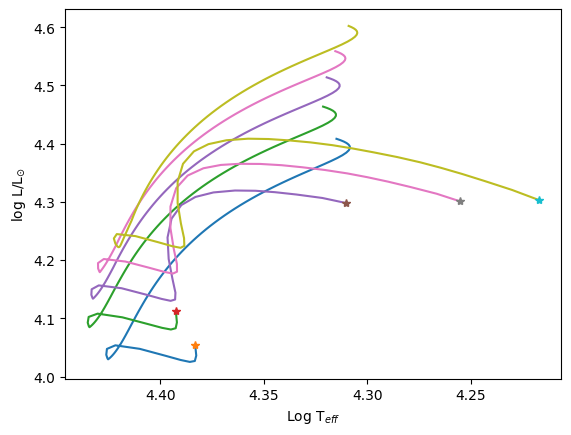

<Figure size 640x480 with 0 Axes>

In [9]:
# for m in masses:
for m in [12.0,12.5,13.0,13.5,14.0]:
    bestfitdir = '../mesafolder/work/LOGS/M'+str(m)+'_alpha0.01'+'_v156/'
#     bestfitdir = "../mesafolder/work/LOGS/M12.0_alpha0.01_v156/"
    star = ms.MesaData(str(bestfitdir + "history.data"))
    Teff = star.data('log_Teff')
    L = star.data('log_L')
    #uncomment for separate figures:
#     plt.figure()
    plt.plot(Teff,L)
    # star2 = ms.MesaData("LOGS/Z02Models/M9.2_alpha0.01_v50/history.data")
    # plt.plot(star2.data('log_Teff'),star2.data('log_L'),'--')
    # modnum = 70
    modnum = 1
    plt.plot(star.data_at_model_number('log_Teff',modnum),star.data_at_model_number('log_L',modnum),'*')
plt.gca().invert_xaxis()
plt.xlabel("Log T$_{eff}$")
plt.ylabel("log L/L$_{\odot}$")
plt.show()
plt.savefig("/Users/skbowes/research/jup/plots")

In [21]:
def chigrid(x):
    return x

In [ ]:
fig, axs = plt.subplots(3,2,sharex=True, sharey=True,figsize=(6.4,10)) #sharex=True,
vminimum = 0
vmaximum = 0.0004
colmap = "Oranges"
# plt.xlabel('Velocity (km/s)')
# plt.ylabel('Convective Overshoot')
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# plt.xticks(velocity)

# fig, axes = plt.subplots(2,3, figsize=(15,10))
axs[2,1].set_visible(False)

# axs[0,0].xaxis.set_tick_params(labelbottom=False)
# axs[0,1].xaxis.set_tick_params(labelbottom=False)
# axs[1,0].xaxis.set_tick_params(labelbottom=False)
# axs[1,1].xaxis.set_tick_params(labelbottom=False)
# axs[2,0]set_xticks([])
# axs[1][0].set_position([0.24,0.125,0.228,0.343])
# axs[1][1].set_position([0.55,0.125,0.228,0.343])

plt.setp(axs[0,0].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[0,1].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[1,0].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[1,1].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
# plt.setp(axs[2,0].get_xticklabels(), rotation=70, ha="right", rotation_mode="anchor")
plt.setp(axs[2,1].get_xticklabels(), rotation=70, ha="right", rotation_mode="anchor")
plt.xticks(velocity, fontsize=5)
# axs.set_xticks([148,150,152,154,156,158,160])


# dx = 5/72.; dy = 0/72. 
# offset = plt.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# # apply offset transform to all x ticklabels.
# for label in ax.xaxis.get_majorticklabels():
#     label.set_transform(label.get_transform() + offset)

im1 = axs[0,0].pcolormesh(velocity, overshoot, chigrid(masses[0]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[0,0].title.set_text(str(masses[0])+"$M_{\odot}$")
im2 = axs[0,1].pcolormesh(velocity, overshoot, chigrid(masses[1]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[0,1].title.set_text(str(masses[1])+"$M_{\odot}$")
im3 = axs[1,0].pcolormesh(velocity, overshoot, chigrid(masses[2]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[1,0].title.set_text(str(masses[2])+"$M_{\odot}$")
im4 = axs[1,1].pcolormesh(velocity, overshoot, chigrid(masses[3]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[1,1].title.set_text(str(masses[3])+"$M_{\odot}$")

im5 = axs[2,0].pcolormesh(velocity, overshoot, chigrid(masses[4]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[2,0].title.set_text(str(masses[4])+"$M_{\odot}$")
# im6 = axs[2,1].pcolormesh(velocity, overshoot, chigrid(masses[3]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
# axs[2,1].title.set_text(str(masses[3])+"$M_{\odot}$")

fig.subplots_adjust(right=0.8)
fig.text(0.5, 0.05, 'Velocity (km/s)', ha='center', va='center')
fig.text(0.04, 0.5, 'Convective Overshoot', ha='center', va='center', rotation='vertical')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax)
# plt.tight_layout()

plt.savefig("lamscochis_highm_pmode_refined_sec39.png", bbox_inches = 'tight', dpi =600)

In [ ]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
vminimum = 0
vmaximum = 0.0004
colmap = "Oranges"
# plt.xlabel('Velocity (km/s)')
# plt.ylabel('Convective Overshoot')
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# plt.xticks(velocity)
plt.setp(axs[0,0].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[0,1].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[1,1].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[1,0].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.xticks(velocity)
im1 = axs[0,0].pcolormesh(velocity, overshoot, chigrid(masses[0]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[0,0].title.set_text(str(masses[0])+"$M_{\odot}$")
im2 = axs[0,1].pcolormesh(velocity, overshoot, chigrid(masses[1]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[0,1].title.set_text(str(masses[1])+"$M_{\odot}$")
im3 = axs[1,0].pcolormesh(velocity, overshoot, chigrid(masses[2]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[1,0].title.set_text(str(masses[2])+"$M_{\odot}$")
im4 = axs[1,1].pcolormesh(velocity, overshoot, chigrid(masses[3]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[1,1].title.set_text(str(masses[3])+"$M_{\odot}$")
fig.subplots_adjust(right=0.8)
fig.text(0.5, 0.001, 'Velocity (km/s)', ha='center', va='center')
fig.text(0.04, 0.5, 'Convective Overshoot', ha='center', va='center', rotation='vertical')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax)

plt.savefig("lamscochis1_lowm_gmode_refined_sec39.png", bbox_inches = 'tight', dpi =600)

fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
plt.xticks(velocity)
plt.setp(axs[0,0].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[0,1].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[1,1].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[1,0].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
im1 = axs[0,0].pcolormesh(velocity, overshoot, chigrid(masses[4]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[0,0].title.set_text(str(masses[4])+"$M_{\odot}$")
# plt.xlabel('Virial mass ($10^{14} M_{\odot}$)',fontsize=14)
im2 = axs[0,1].pcolormesh(velocity, overshoot, chigrid(masses[5]), vmin=vminimum, vmax=vmaximum,cmap=colmap, shading = 'nearest')
axs[0,1].title.set_text(str(masses[5])+"$M_{\odot}$")
im3 = axs[1,0].pcolormesh(velocity, overshoot, chigrid(masses[6]), vmin=vminimum, vmax=vmaximum,cmap=colmap, shading = 'nearest')
axs[1,0].title.set_text(str(masses[6])+"$M_{\odot}$")
im4 = axs[1,1].pcolormesh(velocity, overshoot, chigrid(masses[7]), vmin=vminimum, vmax=vmaximum,cmap=colmap, shading = 'nearest')
axs[1,1].title.set_text(str(masses[7])+"$M_{\odot}$")
fig.subplots_adjust(right=0.8)
fig.text(0.5, 0.001, 'Velocity (km/s)', ha='center', va='center')
fig.text(0.04, 0.5, 'Convective Overshoot', ha='center', va='center', rotation='vertical')
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax)
plt.savefig("lamscochis2_lowm_gmode_refined_sec39.png", bbox_inches = 'tight', dpi =600)


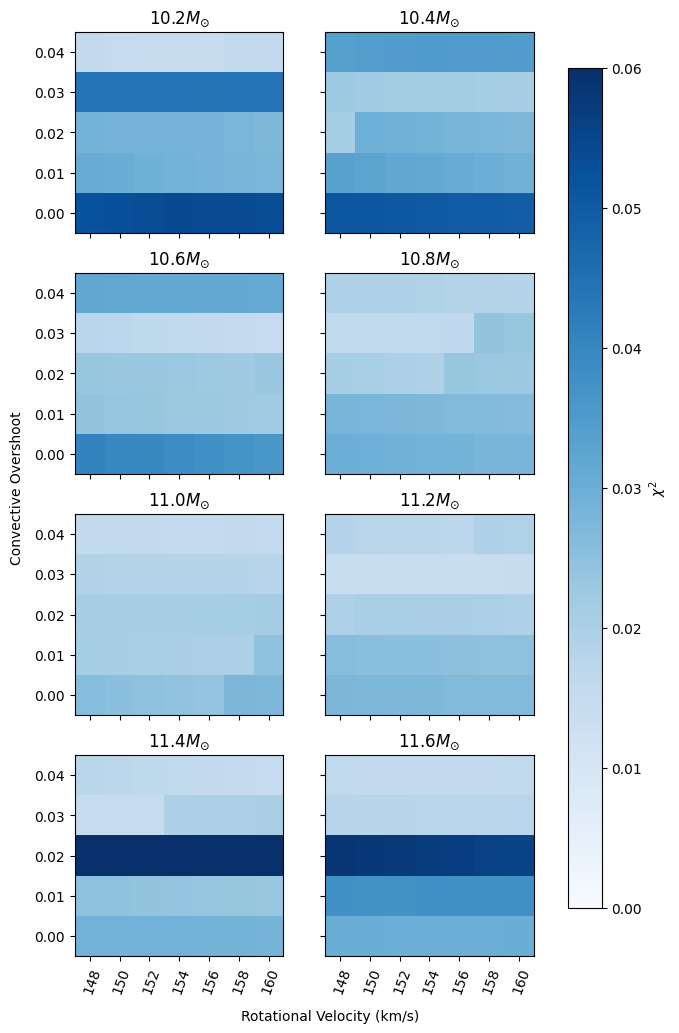

In [44]:
fig, axs = plt.subplots(4,2, sharex=True, sharey=True,figsize=(6.8,12))
vminimum = 0
vmaximum = 0.06
colmap = "Blues"

plt.xticks(velocity)
plt.setp(axs[3,0].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[3,1].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")

im1 = axs[0,0].pcolormesh(velocity, overshoot, chigrid(masses[0]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[0,0].title.set_text(str(masses[0])+"$M_{\odot}$")
# plt.xlabel('Virial mass ($10^{14} M_{\odot}$)',fontsize=14)
im2 = axs[0,1].pcolormesh(velocity, overshoot, chigrid(masses[1]), vmin=vminimum, vmax=vmaximum,cmap=colmap, shading = 'nearest')
axs[0,1].title.set_text(str(masses[1])+"$M_{\odot}$")
im3 = axs[1,0].pcolormesh(velocity, overshoot, chigrid(masses[2]), vmin=vminimum, vmax=vmaximum,cmap=colmap, shading = 'nearest')
axs[1,0].title.set_text(str(masses[2])+"$M_{\odot}$")
im4 = axs[1,1].pcolormesh(velocity, overshoot, chigrid(masses[3]), vmin=vminimum, vmax=vmaximum,cmap=colmap, shading = 'nearest')
axs[1,1].title.set_text(str(masses[3])+"$M_{\odot}$")
im5 = axs[2,0].pcolormesh(velocity, overshoot, chigrid(masses[4]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[2,0].title.set_text(str(masses[4])+"$M_{\odot}$")
# plt.xlabel('Virial mass ($10^{14} M_{\odot}$)',fontsize=14)
im6 = axs[2,1].pcolormesh(velocity, overshoot, chigrid(masses[5]), vmin=vminimum, vmax=vmaximum,cmap=colmap, shading = 'nearest')
axs[2,1].title.set_text(str(masses[5])+"$M_{\odot}$")
im7 = axs[3,0].pcolormesh(velocity, overshoot, chigrid(masses[6]), vmin=vminimum, vmax=vmaximum,cmap=colmap, shading = 'nearest')
axs[3,0].title.set_text(str(masses[6])+"$M_{\odot}$")
im8 = axs[3,1].pcolormesh(velocity, overshoot, chigrid(masses[7]), vmin=vminimum, vmax=vmaximum,cmap=colmap, shading = 'nearest')
axs[3,1].title.set_text(str(masses[7])+"$M_{\odot}$")

fig.subplots_adjust(right=0.8)
fig.text(0.5, 0.06, 'Rotational Velocity (km/s)', ha='center', va='center')
fig.text(0.04, 0.5, 'Convective Overshoot', ha='center', va='center', rotation='vertical')
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax, label = "$\chi^2$")
plt.savefig("blue_lamscochis_lowm_pmode_refined_sec12.png", bbox_inches = 'tight', dpi =600)

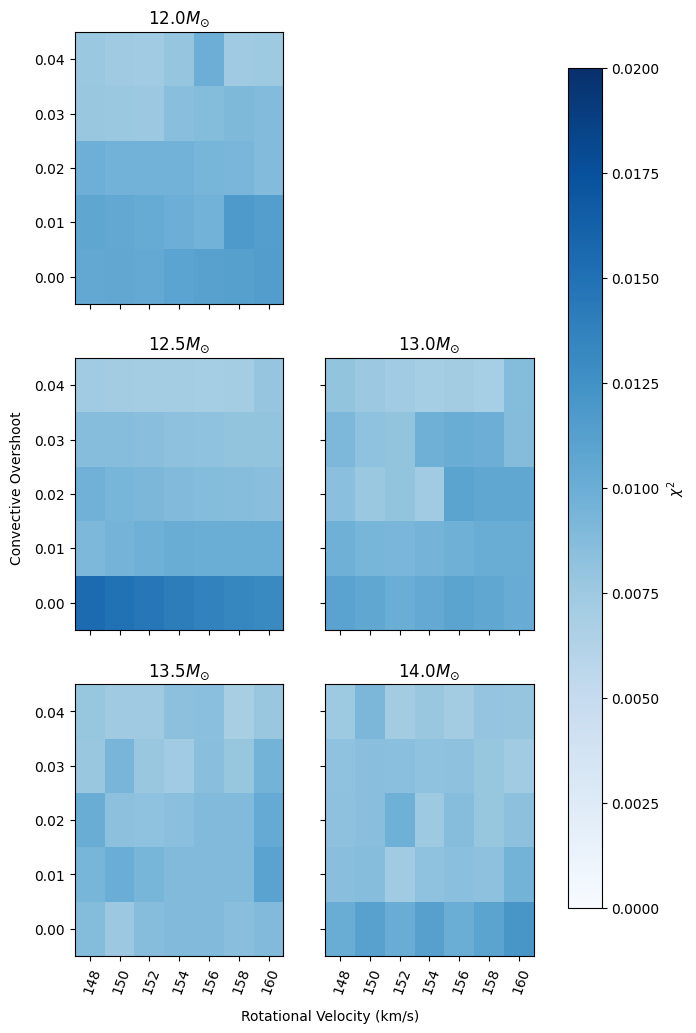

In [32]:
fig, axs = plt.subplots(3,2, sharex=True, sharey=True,figsize=(6.8,12))
vminimum = 0
vmaximum = 0.02
colmap = "Blues"

plt.xticks(velocity)
plt.setp(axs[2,0].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")
plt.setp(axs[2,1].get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")

im1 = axs[0,0].pcolormesh(velocity, overshoot, chigrid(masses[0]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[0,0].title.set_text(str(masses[0])+"$M_{\odot}$")
# plt.xlabel('Virial mass ($10^{14} M_{\odot}$)',fontsize=14)
axs[0,1].set_visible(False)
im3 = axs[1,0].pcolormesh(velocity, overshoot, chigrid(masses[1]), vmin=vminimum, vmax=vmaximum,cmap=colmap, shading = 'nearest')
axs[1,0].title.set_text(str(masses[1])+"$M_{\odot}$")
im4 = axs[1,1].pcolormesh(velocity, overshoot, chigrid(masses[2]), vmin=vminimum, vmax=vmaximum,cmap=colmap, shading = 'nearest')
axs[1,1].title.set_text(str(masses[2])+"$M_{\odot}$")
im5 = axs[2,0].pcolormesh(velocity, overshoot, chigrid(masses[3]), vmin=vminimum, vmax=vmaximum, cmap=colmap, shading = 'nearest')
axs[2,0].title.set_text(str(masses[3])+"$M_{\odot}$")
# plt.xlabel('Virial mass ($10^{14} M_{\odot}$)',fontsize=14)
im6 = axs[2,1].pcolormesh(velocity, overshoot, chigrid(masses[4]), vmin=vminimum, vmax=vmaximum,cmap=colmap, shading = 'nearest')
axs[2,1].title.set_text(str(masses[4])+"$M_{\odot}$")

fig.subplots_adjust(right=0.8)
fig.text(0.5, 0.06, 'Rotational Velocity (km/s)', ha='center', va='center')
fig.text(0.04, 0.5, 'Convective Overshoot', ha='center', va='center', rotation='vertical')
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im1, cax=cbar_ax, label = "$\chi^2$")
plt.savefig("blue_lamscochis_highm_pmode_refined_sec39.png", bbox_inches = 'tight', dpi =600)

In [ ]:
plt.xlabel('Velocities')
plt.ylabel('Convective Overshoot')
plt.pcolormesh(velocity, overshoot, chigrid(2.2), cmap="Greens", shading = 'nearest')
plt.colorbar()
plt.title("$\u03C7^2$ grid")

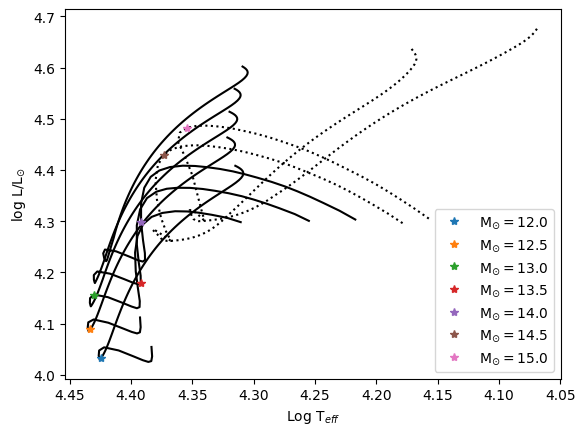

In [47]:
# for m in masses:
for m in [12.0,12.5,13.0,13.5,14.0,14.5, 15.0]:
    bestfitdir = '../mesafolder/work/LOGS/M'+str(m)+'_alpha0.01'+'_v156/'
#     bestfitdir = "../mesafolder/work/LOGS/M12.0_alpha0.01_v156/"
    star = ms.MesaData(str(bestfitdir + "history.data"))
    Teff = star.data('log_Teff')
    L = star.data('log_L')
    #uncomment for separate figures:
#     plt.figure()
    if m < 14.4:
        plt.plot(Teff,L, color='black')
    else:
        plt.plot(Teff,L, linestyle="dotted", color='black')
    # star2 = ms.MesaData("LOGS/Z02Models/M9.2_alpha0.01_v50/history.data")
    # plt.plot(star2.data('log_Teff'),star2.data('log_L'),'--')
    # modnum = 70
    modnum = 20
    plt.plot(star.data_at_model_number('log_Teff',modnum),star.data_at_model_number('log_L',modnum),'*', label = "M$_{\odot} = $" + str(m))
#     print(10**star.data_at_model_number('log_Teff',modnum))
#     print(10**star.data_at_model_number('log_R',modnum))
#     print(star.data_at_model_number('star_age',modnum))
# plt.errorbar(4.3,3.5,xerr=0.06, yerr=0.4)
# plt.errorbar(3.83,1.84,xerr=2.31, yerr=0.4)
# expect 
#plt.errorbar(3.83,1.84,xerr=0.06, yerr=0.4)
plt.gca().invert_xaxis()
plt.xlabel("Log T$_{eff}$")
plt.ylabel("log L/L$_{\odot}$")
plt.legend()
plt.savefig("bestfit_profiles-highmass.png", bbox_inches = 'tight', dpi =600)
plt.show()

In [73]:
#check best chi value overall
ModelFits = []
for m in masses:
    for fov in overshoot:
        for v in velocity:
            directory = '../mesafolder/work/LOGS/M'+str(m)+'_alpha'+str(fov)+'_v'+str(v)
            flist = glob.glob(directory + "/morefrequencies*_split.txt")
            #print(directory,flist)
            for f in flist:
                profile = f.split('_')
                if profile[3] == 'split':
                    continue
                profile = profile[2].split('s')[1]
                ModFileName = directory+"/profile"+str(profile)+".data"
                
                Model = ModelData(m,v,fov,profile)
                
                star = ms.MesaData(ModFileName)

                
                # read frequency data
                FreqFile = open(f)
                data = np.loadtxt(FreqFile, skiprows=6)
                FreqFile.close()
                if data.ndim < 2:
                    continue
                
                Model.mass = data[0,1]
                radius = data[0,2]
                    
                ell = data[:,2]
                em = data[:,3]
#                 n = data[:,4]
                ModelFreqs = data[:,7]
                ModelGrowth = data[:,9]
                # get mass and radius for scaling
                
                scalefactor = np.sqrt(6.672e-8 * Model.mass / (radius)**3) / (2 * np.pi)
#                 ModelFreqs = ModelFreqs * scalefactor * 86400 # put frequencies in c/d
                
                # find differences in model vs observed frequencies:
                chiSquare = 0
                Model.ell = np.zeros(len(ObsFreqs))
                Model.em = np.zeros(len(ObsFreqs))
                Model.freqs = np.zeros(len(ObsFreqs))
                i = 0
                if len(ModelFreqs[ModelGrowth>0]) < 1:
                    continue
                for freq in ObsFreqs:
                    
                    bestIndex = np.argmin(np.abs(freq-ModelFreqs[ModelGrowth>0]))
                    
                    chiSquare +=(freq - ModelFreqs[bestIndex])**2
                    Model.ell[i] = ell[bestIndex]
                    Model.em[i] = em[bestIndex]
                    Model.freqs[i] = ModelFreqs[bestIndex]
                    
                    i = i + 1
                    
                chiSquare = chiSquare/len(ObsFreqs)
                if chiSquare < Model.chi:
                    Model.chi = chiSquare
                ModelFits.append(Model)
                
print(len(ModelFits))
BestFit = ModelData(1,1,1,1)
    #compares to that model, then to every model after
for m in ModelFits:
    if m.chi < BestFit.chi:
        BestFit = m
print(BestFit.mass/1.989e33, BestFit.v, BestFit.fov, BestFit.prof, BestFit.chi)

0
5.027652086475616e-34 1 1 1 1e+99


In [33]:
#create columns
overshootlist = []
velocitylist = []
for i in range(len(overshoot)):
    for j in range(len(velocity)):
        velocitylist.append(velocity[j])
for k in range(len(overshoot)):
    for n in range(len(velocity)):
        overshootlist.append(overshoot[k])

In [37]:
sample = chigrid(2.1)[1]
ModelFits1 = chigrid(2.1)[2]

In [83]:
ModelFitspd = chigrid(2.1)
#make pandas dataframe
# df = pd.DataFrame([velocitylist,overshootlist,sample], index=['vel', 'fov', 'chi'])
df = pd.DataFrame(ModelFitspd[2], columns = ['mass', 'velocity', 'overshoot', 'profile', 'chi'])

In [84]:
df

,mass,velocity,overshoot,profile,chi
0,2.09936,200,0.00,3,0.111
1,2.09936,200,0.00,11,0.111
2,2.09936,200,0.00,8,0.882
3,2.09936,200,0.00,2,1.340
4,2.09936,200,0.00,10,0.111
...,...,...,...,...,...
418,2.09936,290,0.04,4,0.111
419,2.09936,290,0.04,9,0.111
420,2.09936,290,0.04,1,0.111
421,2.09936,290,0.04,7,0.792


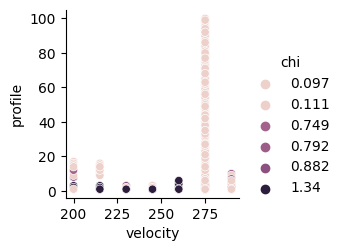

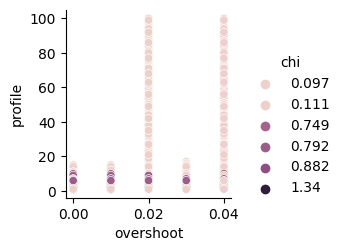

In [92]:
sns.pairplot(df, hue = 'chi', x_vars='velocity', y_vars='profile')
# check what overshoot this is 
sns.pairplot(df, hue = 'chi', x_vars='overshoot', y_vars='profile')

In [ ]:
data2 = np.loadtxt(bestfitdir + "frequencies15_nad.txt",skiprows=6)
plt.figure()
plt.plot(data2[:,7],data2[:,9],'o')
#plt.plot(nonad2[:,7],nonad2[:,9],'d')
plt.plot(ObsFreqs,0.1 * np.ones(len(ObsFreqs)),'x')
plt.grid()
plt.xlabel("Frequency (c/d)")
plt.ylabel("$\eta$")

In [ ]:
print(BestFit.freqs)
print(BestFit.ell)
print(BestFit.em)
print(ObsFreqs)